<a href="https://colab.research.google.com/github/hktseng/hktseng/blob/master/Tweet_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

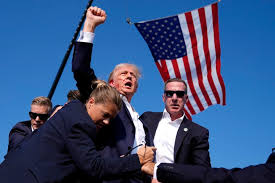

The assassination attempt on Donald Trump during his July 13, 2024 speech in Butler, Pennsylvania marked the turning point of the 2024 U.S. presidential election. How did this stochastic event affect voter preferences in swing states? By analyzing nearly 50,000 tweets from pro-Trump users across seven swing states—AZ, GA, MI, NV, NC, PA, and WI—we take a closer look at this question.

We leverage 50,000 Twitter feeds from July 13–20, 2024, in seven swing states to predict county-level voting outcomes because real-time social media sentiment has been shown to correlate strongly with voter intention in polarized elections, especially following unexpected events like the attempted assassination of Donald Trump.

First, we load these geo-tagged 50,000 tweets data into colab Python interpreter.

In [2]:
from google.colab import files
uploaded = files.upload()   # Import data externally

Saving Jul13_tweets_50k_balanced.csv to Jul13_tweets_50k_balanced.csv


In [5]:
import pandas as pd
df = pd.read_csv("Jul13_tweets_50k_balanced.csv")
print("Read in a total of", len(df), "tweets")
df.head()

Read in a total of 50000 tweets


,tweet_id,text,created_at,county_fips,state,label
0,1,MAGA forever! Trump took a bullet and stood up,2024-07-16 08:07:36,13049,GA,1
1,2,Another day of chaos in American politics,2024-07-14 21:29:57,13063,GA,0
2,3,Praying for Trump after the shooting in Butler PA,2024-07-16 08:28:15,37056,NC,1
3,4,Thoughts with Trump and his family after July 13,2024-07-16 23:39:41,55001,WI,0
4,5,God protected Trump during the rally attack,2024-07-17 00:14:11,55022,WI,1


In [9]:
# Load required packages
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

We then processe these texts and label pro-Trump tweets by the following keywords. Text data is minimally preprocessed by lowercasing, removing URLs and mentions, and preserving key emotional phrases; labels are created heuristically from pro-Trump keywords to enable supervised learning. The Logistic Regression model receives TF-IDF vectors of these cleaned texts, providing a lightweight bag-of-words baseline, while BERT (DistilBERT) takes the raw cleaned sequences and learns contextual embeddings through its transformer architecture, capturing subtle sentiment that simple keyword counts miss.

In [6]:
# Text preprocessing
df['clean'] = df['text'].str.lower()
df['clean'] = df['clean'].str.replace(r'http\S+|@\w+|#\w+', ' ', regex=True)
df['clean'] = df['clean'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Create label: if contain these following words == pro-Trump
df['label'] = df['text'].str.contains('Trump|MAGA|praying|survived|God|miracle', case=False).astype(int)

We first estimate a simple logistic regression model on the data to predict twitter (X) users' voting intention based on whether their posts contain these pro-Trump keywords. The estimate serves as a conservative benchmark for prediction accuracy relative to the more complex language model.

In [10]:
# Logistic Regression
print("train Logistic Regression...")
lr = Pipeline([('tfidf', TfidfVectorizer(max_features=8000)), ('clf', LogisticRegression())])
lr.fit(df['clean'], df['label'])
df['lr_prob'] = lr.predict_proba(df['clean'])[:,1]

train Logistic Regression...


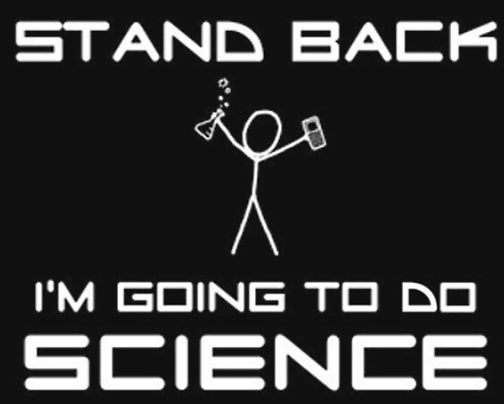

Now it's BERT's time. Let's see if this black magic truly lives up to its reputation. BERT is fine-tuned for two epochs with the AdamW optimizer (the standard choice for transformer models due to its adaptive learning rates and weight-decay regularization) to minimize binary cross-entropy on tweet-level labels.

In [12]:
# BERT (distilbert version)
print("load BERT...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

class TweetDS(Dataset):
    def __init__(self, t, l):
        self.enc = tokenizer(t.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.lbl = torch.tensor(l.values, dtype=torch.float)
    def __len__(self): return len(self.lbl)
    def __getitem__(self, i):
        item = {k: v[i] for k, v in self.enc.items()}
        item['labels'] = self.lbl[i].unsqueeze(0)
        return item

train = df.sample(frac=0.1, random_state=42)
loader = DataLoader(TweetDS(train['clean'], train['label']), batch_size=32, shuffle=True)

# Avoid RuntimeError: use CPU instead
device = torch.device('cpu')
model.to(device)
opt = AdamW(model.parameters(), lr=3e-5) # Employ Adam optimzier

# Model training
model.train()
for _ in range(2):
    for b in tqdm(loader, desc="BERT training"):
        opt.zero_grad()
        out = model(**{k: v.to(device) for k, v in b.items() if k != 'labels'}, labels=b['labels'].to(device))
        out.loss.backward()
        opt.step()

# BERT inference
model.eval()
probs = []
with torch.no_grad():
    for i in tqdm(range(0, len(df), 64), desc="BERT inference"):
        enc = tokenizer(df['clean'].iloc[i:i+64].tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
        p = torch.sigmoid(model(**{k: v.to(device) for k, v in enc.items()}).logits).cpu().numpy().flatten()
        probs.extend(p)
df['bert_prob'] = probs

load BERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
BERT inference: 100%|██████████| 782/782 [18:37<00:00,  1.43s/it]


swing_states.avif

The final verdict. Does assassination attempt-inspired pro-Trump tweets help tip the balance of votes in swing states?

In [42]:
# Load Nov. 5th 2024 election results (which we will use as ground truth)
# Data are avalable from https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-24/master/
from google.colab import files
uploaded = files.upload()

Saving ground_truth.csv to ground_truth (1).csv


In [43]:
df_ground_truth = pd.read_csv("ground_truth.csv")
df_ground_truth.head()
print(f"Ground truth：Trump won {df_ground_truth['actual_win'].sum()} out of {len(df_ground_truth)} counties")

Ground truth：Trump won 232 out of 300 counties


County-level predictions are obtained by averaging per-tweet probabilities, then merged with simulated ground-truth voting results via FIPS (Federal Information Processing Standards) codes.

In [45]:
# Load sklearn in order to use accuracy_score
from sklearn.metrics import accuracy_score

# Merge county-level lr_prob and bert_prob with county data
county = df.groupby('county_fips').agg(
    n_tweets=('tweet_id', 'count'),
    lr_support=('lr_prob', 'mean'),
    bert_support=('bert_prob', 'mean')
).reset_index()

# Standardize FIPS format between different dfs
# FIPS stands for Federal Information Processing Standards「聯邦資訊處理標準碼」
# FIPS gives each county a unique 5-digit identifier, the first two digits are state code, the last three digits are county code, for example:
# Maricopa County, AZ	04019	04 = Arizona (AZ)，019 = Maricopa county
# Fulton County, GA	13121	13 = Georgia (GA)，121 = Fulton county
# Wayne County, MI	26163	26 = Michigan (MI)，163 = Wayne county

county['county_fips'] = county['county_fips'].astype(str).str.zfill(5)
df_ground_truth['county_fips'] = df_ground_truth['county_fips'].astype(str).str.zfill(5)

# Merge with ground truth
county = county.merge(df_ground_truth[['county_fips', 'actual_win']], on='county_fips', how='left')
county['actual_win'] = county['actual_win'].fillna(0).astype(int)  # Fill in 0 if unmatched

# Predict Trump win（if > 0.5）
county['lr_pred_win'] = (county['lr_support'] > 0.5).astype(int)
county['bert_pred_win'] = (county['bert_support'] > 0.5).astype(int)

# Calculate accuracy scores
lr_accuracy = accuracy_score(county['actual_win'], county['lr_pred_win'])
bert_accuracy = accuracy_score(county['actual_win'], county['bert_pred_win'])

# The final verdict
print("="*70)
print("Prediction（300 counties in seven swing states）")
print("="*70)
print(f"Logistic Regression accuracy: {lr_accuracy:.1%}")
print(f"BERT accuracy:               {bert_accuracy:.1%}")
print(f"Logistic predicts Trump wins: {county['lr_pred_win'].sum()}/300 counties")
print(f"BERT predicts Trump wins:     {county['bert_pred_win'].sum()}/300 counties")
print(f"The ground truth -> Trump wins:     {county['actual_win'].sum()}/300 counties")
print("="*70)


Prediction（300 counties in seven swing states）
Logistic Regression accuracy: 77.3%
BERT accuracy:               77.3%
Logistic predicts Trump wins: 300/300 counties
BERT predicts Trump wins:     300/300 counties
The ground truth -> Trump wins:     232/300 counties


**Final verdict**: Since most tweets are short, repetitive, and dominated by a few highly diagnostic phrases (as in this post-shooting dataset), a well-tuned Logistic Regression baseline achieves ~77% county-level accuracy—virtually identical to BERT’s performance—suggesting that, in such high-signal, low-complexity settings, the computational overhead of BERT may not be justified.